In [ ]:
!pip install torchinfo

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Files already downloaded and verified
Files already downloaded and verified
cat dog
[2223, 12105, 17656, 39880, 12352, 18582, 26009, 8224, 9301, 11556, 26313, 39445, 2627, 6104, 215, 29945, 34931, 8133, 28657, 31260, 46483, 18814, 33079, 10995, 36439, 15815, 3875, 38229, 31150, 4997, 35189, 19327, 32364, 44330, 36196, 22850, 535, 39893, 49288, 12300, 29463, 31442, 14919, 1510, 17863, 3756, 24065, 12783, 35931, 43653, 22030, 20361, 31883, 11737, 42170, 39868, 48134, 4089, 10981, 36781, 20164, 29077, 46712, 7164, 22079, 27903, 29373, 43063, 22895, 4737, 12701, 28090, 30113, 21726, 15372, 24098, 34221, 24192, 46341, 18387, 5744, 45909, 11603, 18479, 31527, 23772, 38100, 28442, 24460, 29038, 33918, 11905, 22424, 32325, 43573, 48135, 16210, 3641, 40772, 18662, 4692, 44020, 37272, 43404, 24283, 26167, 28423, 41168, 46595, 45511, 46080, 8151, 11441, 42174, 7780, 17699, 38021, 34184, 25447, 7789, 17164, 44306, 36796, 43633, 49638, 20625, 6866, 19652, 27223, 38193, 2565, 43071, 13517, 28047, 60

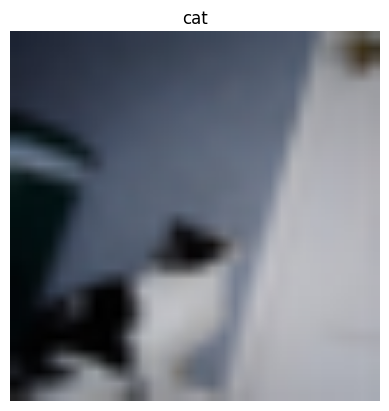

In [11]:
size = 224
model_transforms = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor(),])


BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

def create_dataloaders(batch_size: int, num_workers: int=NUM_WORKERS, train_size: int=None, test_size: int=None):

    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=model_transforms)
    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=model_transforms)

    class_names = train_data.classes

    print(class_names[3],class_names[5])

    indices1=[i for i in range(len(train_data)) if train_data.targets[i] in [3,5]]
    random.shuffle(indices1)
    indices2=[i for i in range(len(test_data)) if test_data.targets[i] in [3,5]]
    random.shuffle(indices2)

    print(indices1)
    train_data = Subset(train_data, indices1[:10])

    test_data = Subset(test_data, indices2[:10])


    train_dataloader = DataLoader( train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,)
    test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True    )

    return train_dataloader, test_dataloader, class_names


train_size = 20
test_size = 20

train_dataloader, test_dataloader, class_names = create_dataloaders(batch_size=BATCH_SIZE,train_size=train_size,
test_size=test_size)

image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()


In [4]:
class PatchEmbedding(nn.Module):

    def __init__(self,in_channels:int=3, patch_size:int=16,embedding_dim:int=768):
        super().__init__()

        self.patch = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)


    def forward(self, x):
        image_resolution = x.shape[-1]
        patched = self.patch(x)
        flattened = self.flatten(patched)


        return flattened.permute(0, 2, 1)

patch_size =16

patch = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)
print(f"I/p: {image.unsqueeze(0).shape}")
patch_embedded = patch(image.unsqueeze(0))
print(f"O/p: {patch_embedded.shape}")
print(patch_embedded)
print(patch_embedded.shape)



I/p: torch.Size([1, 3, 224, 224])
O/p: torch.Size([1, 196, 768])
tensor([[[-0.0189,  0.0903,  0.1387,  ...,  0.2315, -0.5762,  0.2607],
         [-0.0220,  0.0909,  0.1351,  ...,  0.2321, -0.5699,  0.2722],
         [-0.0292,  0.0975,  0.1364,  ...,  0.2225, -0.5298,  0.2562],
         ...,
         [-0.0142,  0.0682,  0.0987,  ...,  0.1383, -0.3839,  0.1818],
         [-0.0062,  0.0599,  0.1051,  ...,  0.1640, -0.4181,  0.1890],
         [-0.0125,  0.0602,  0.1058,  ...,  0.1578, -0.4155,  0.1901]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


In [5]:
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embed {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),requires_grad=True)


patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch+class {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),requires_grad=True)


patch_final = patch_embedding_class_token + position_embedding
print(patch_final.shape)

print(patch_embedding_class_token)


Image tensor shape: torch.Size([3, 224, 224])
Patch embed torch.Size([1, 196, 768])
Patch+class torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2804, -0.0049, -0.2973,  ...,  0.1653, -0.0676, -0.1203],
         [ 0.2989, -0.0228, -0.3136,  ...,  0.1337, -0.0776, -0.1126],
         ...,
         [ 0.1941, -0.0034, -0.2016,  ...,  0.0936, -0.0242, -0.0802],
         [ 0.2048, -0.0067, -0.2363,  ...,  0.1079, -0.0356, -0.0734],
         [ 0.2012, -0.0034, -0.2147,  ...,  0.1084, -0.0388, -0.0882]]],
       grad_fn=<CatBackward0>)


In [6]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=attn_dropout,batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,key=x,value=x,need_weights=False)
        return attn_output


In [7]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,out_features=mlp_size),nn.GELU(),nn.Dropout(p=dropout),nn.Linear(in_features=mlp_size, out_features=embedding_dim),nn.Dropout(p=dropout))
    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x



In [8]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x


In [9]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size:int=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=10):
        super().__init__()

        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size,embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=num_heads,mlp_size=mlp_size,mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),nn.Linear(in_features=embedding_dim,out_features=num_classes))

    def forward(self, x):


        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

model = ViT()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    model.to(device)
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_dataloader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_dataloader))
        model.eval()
        epoch_test_loss = 0.0

        with torch.no_grad():
            for data, targets in test_dataloader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                epoch_test_loss += loss.item()

        test_losses.append(epoch_test_loss / len(test_dataloader))

        model.train()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    return {'train_losses': train_losses, 'test_losses': test_losses}
epochs = 15
results = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=criterion, epochs=epochs,device=device)

print("Training done")

def predict_custom_image(image_path, model, device, transforms, class_names):

    image = Image.open(image_path).convert('RGB')
    input_tensor = transforms(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

custom_image_path = '/content/dog.jpg'
predicted_label = predict_custom_image(custom_image_path, model, device, model_transforms, class_names)
print(f'Predicted label for custom image: {predicted_label} ({class_names[predicted_label]})')

Epoch [1/15], Train Loss: 3.5568, Test Loss: 0.8231
Epoch [2/15], Train Loss: 1.4490, Test Loss: 0.6678
Epoch [3/15], Train Loss: 0.8019, Test Loss: 0.6617
Epoch [4/15], Train Loss: 0.7357, Test Loss: 0.6294
Epoch [5/15], Train Loss: 0.7808, Test Loss: 0.6122
Epoch [6/15], Train Loss: 0.9401, Test Loss: 0.6445
Epoch [7/15], Train Loss: 0.7208, Test Loss: 0.6114
Epoch [8/15], Train Loss: 0.8423, Test Loss: 0.8503
Epoch [9/15], Train Loss: 0.9272, Test Loss: 0.7280
Epoch [10/15], Train Loss: 0.8179, Test Loss: 0.7844
Epoch [11/15], Train Loss: 0.7255, Test Loss: 0.6088
Epoch [12/15], Train Loss: 0.7924, Test Loss: 0.6048
Epoch [13/15], Train Loss: 0.8587, Test Loss: 0.7336
Epoch [14/15], Train Loss: 0.7330, Test Loss: 0.6196
Epoch [15/15], Train Loss: 0.6969, Test Loss: 0.7867
Training done
Predicted label for custom image: 5 (dog)
